# Inference Demo for Mellotron on Google COLAB
by [Hyungon Ryu](https://github.com/yhgon)  | NVAITC Sr. Data Scientist | Center Lead @ NVIDIA 


modification from original inference.ipynb

This notebook requires a GPU runtime to run.
Please select the menu option **"Runtime"** -> **"Change runtime type"**, select **"Hardware Accelerator"** -> **"GPU"** and click **"SAVE"**


## Model Description

Mellotron: a multispeaker voice synthesis model based on Tacotron 2 GST that can make a voice emote and sing without emotive or singing training data.

By explicitly conditioning on rhythm and continuous pitch contours from an audio signal or music score, Mellotron is able to generate speech in a variety of styles ranging from read speech to expressive speech, from slow drawls to rap and from monotonous voice to singing voice.


## DevOps for Google Colab
install required python modules and APEX

In [ ]:
!nvidia-smi

Tue Aug 11 09:51:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%time
%%bash
pip install matplotlib==2.1.0 tensorflow==1.15 inflect==0.2.5 librosa==0.6.0 scipy==1.0.0 tensorboardX==1.1 Unidecode==1.0.22 pillow nltk==3.4.5 jamo==0.4.1  music21 vamp > /dev/null
pip install matplotlib==2.1.0 tensorflow==1.15 inflect==0.2.5 librosa==0.6.0 scipy==1.0.0 tensorboardX==1.1 Unidecode==1.0.22 pillow nltk==3.4.5 jamo==0.4.1  music21 vamp 

ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.0.0 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: seaborn 0.10.1 has requirement matplotlib>=2.1.2, but you'll have matplotlib 2.1.0 which is incompatible.
ERROR: seaborn 0.10.1 has requirement scipy>=1.0.1, but you'll have scipy 1.0.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.0.0 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.1.0 which is incompatible.
ERROR: cvxpy 1.0.31 has requirement scipy>=1.1.0, but you'll have scipy 1.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


CPU times: user 10.3 ms, sys: 5.01 ms, total: 15.3 ms
Wall time: 2min 7s


In [ ]:
%%time
%%bash
git clone https://github.com/NVIDIA/apex
cd apex
pip install  --no-cache-dir ./ # only python  

Processing /content/apex
  Created wheel for apex: filename=apex-0.1-cp36-none-any.whl size=192840 sha256=db2ce024160639ef073131fd0b8253f94b86a7f19be400802ed531bc84d27722
  Stored in directory: /tmp/pip-ephem-wheel-cache-jopbu3x6/wheels/b1/3a/aa/d84906eaab780ae580c7a5686a33bf2820d8590ac3b60d5967
Successfully built apex


Cloning into 'apex'...


CPU times: user 5.14 ms, sys: 4.76 ms, total: 9.9 ms
Wall time: 15.6 s


In [ ]:
%%bash
git clone https://github.com/NVIDIA/mellotron.git
cd mellotron
git submodule init
git submodule update

Submodule path 'waveglow': checked out '2fd4e63e2918012f55eac2c8a8e75622a39741be'


Cloning into 'mellotron'...
Submodule 'waveglow' (https://github.com/NVIDIA/waveglow.git) registered for path 'waveglow'
Cloning into '/content/mellotron/waveglow'...


## download official checkpoint
use google drive utilities

In [ ]:
%%bash
wget -N  -q https://raw.githubusercontent.com/yhgon/colab_utils/master/gfile.py
python gfile.py -u 'https://drive.google.com/open?id=1ZesPPyRRKloltRIuRnGZ2LIUEuMSVjkI' -f 'mellotron_libritts.pt'
python gfile.py -u 'https://drive.google.com/open?id=1Rm5rV5XaWWiUbIpg5385l5sh68z2bVOE' -f 'waveglow_256channels_v4.pt'

It took  2.42sec to download 121.9 MB mellotron_libritts.pt 
It took  11.31sec to download 1.3 GB waveglow_256channels_v4.pt 


## Patchs
It's temporal solution for inference on COLAB, (TODO code clean )
- modify CMUDict directories in `hparams.py` with `cmudict_path="/content/mellotron/data/cmu_dictionary"`
- ignore distributed module using `train_utils.py` instead of `train.py`
- modify CMUDict directories for `CMUDICT_PATH`  `/content/mellotron/data/cmu_dictionary`  

In [ ]:
#@title
%%file hparams.py
import tensorflow as tf
from text.symbols import symbols


def create_hparams(hparams_string=None, verbose=False):
    """Create model hyperparameters. Parse nondefault from given string."""

    hparams = tf.contrib.training.HParams(
        ################################
        # Experiment Parameters        #
        ################################
        epochs=50000,
        iters_per_checkpoint=500,
        seed=1234,
        dynamic_loss_scaling=True,
        fp16_run=False,
        distributed_run=False,
        dist_backend="nccl",
        dist_url="tcp://localhost:54321",
        cudnn_enabled=True,
        cudnn_benchmark=False,
        ignore_layers=['speaker_embedding.weight'],

        ################################
        # Data Parameters             #
        ################################
        training_files='filelists/ljs_audiopaths_text_sid_train_filelist.txt',
        validation_files='filelists/ljs_audiopaths_text_sid_val_filelist.txt',
        text_cleaners=['english_cleaners'],
        p_arpabet=1.0,
        cmudict_path="/content/mellotron/data/cmu_dictionary",

        ################################
        # Audio Parameters             #
        ################################
        max_wav_value=32768.0,
        sampling_rate=22050,
        filter_length=1024,
        hop_length=256,
        win_length=1024,
        n_mel_channels=80,
        mel_fmin=0.0,
        mel_fmax=8000.0,
        f0_min=80,
        f0_max=880,
        harm_thresh=0.25,

        ################################
        # Model Parameters             #
        ################################
        n_symbols=len(symbols),
        symbols_embedding_dim=512,

        # Encoder parameters
        encoder_kernel_size=5,
        encoder_n_convolutions=3,
        encoder_embedding_dim=512,

        # Decoder parameters
        n_frames_per_step=1,  # currently only 1 is supported
        decoder_rnn_dim=1024,
        prenet_dim=256,
        prenet_f0_n_layers=1,
        prenet_f0_dim=1,
        prenet_f0_kernel_size=1,
        prenet_rms_dim=0,
        prenet_rms_kernel_size=1,
        max_decoder_steps=1000,
        gate_threshold=0.5,
        p_attention_dropout=0.1,
        p_decoder_dropout=0.1,
        p_teacher_forcing=1.0,

        # Attention parameters
        attention_rnn_dim=1024,
        attention_dim=128,

        # Location Layer parameters
        attention_location_n_filters=32,
        attention_location_kernel_size=31,

        # Mel-post processing network parameters
        postnet_embedding_dim=512,
        postnet_kernel_size=5,
        postnet_n_convolutions=5,

        # Speaker embedding
        n_speakers=123,
        speaker_embedding_dim=128,

        # Reference encoder
        with_gst=True,
        ref_enc_filters=[32, 32, 64, 64, 128, 128],
        ref_enc_size=[3, 3],
        ref_enc_strides=[2, 2],
        ref_enc_pad=[1, 1],
        ref_enc_gru_size=128,

        # Style Token Layer
        token_embedding_size=256,
        token_num=10,
        num_heads=8,

        ################################
        # Optimization Hyperparameters #
        ################################
        use_saved_learning_rate=False,
        learning_rate=1e-3,
        learning_rate_min=1e-5,
        learning_rate_anneal=50000,
        weight_decay=1e-6,
        grad_clip_thresh=1.0,
        batch_size=32,
        mask_padding=True,  # set model's padded outputs to padded values

    )

    if hparams_string:
        tf.compat.v1.logging.info('Parsing command line hparams: %s', hparams_string)
        hparams.parse(hparams_string)

    if verbose:
        tf.compat.v1.logging.info('Final parsed hparams: %s', hparams.values())

    return hparams


Writing hparams.py


In [ ]:
#@title
%%file train_utils.py
import os
import time
import argparse
import math
from numpy import finfo

import torch
#from distributed import apply_gradient_allreduce
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader

from model import Tacotron2
from data_utils import TextMelLoader, TextMelCollate
from loss_function import Tacotron2Loss
#from logger import Tacotron2Logger
from hparams import create_hparams


def reduce_tensor(tensor, n_gpus):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.ReduceOp.SUM)
    rt /= n_gpus
    return rt


def init_distributed(hparams, n_gpus, rank, group_name):
    assert torch.cuda.is_available(), "Distributed mode requires CUDA."
    print("Initializing Distributed")

    # Set cuda device so everything is done on the right GPU.
    torch.cuda.set_device(rank % torch.cuda.device_count())

    # Initialize distributed communication
    dist.init_process_group(
        backend=hparams.dist_backend, init_method=hparams.dist_url,
        world_size=n_gpus, rank=rank, group_name=group_name)

    print("Done initializing distributed")


def prepare_dataloaders(hparams):
    # Get data, data loaders and collate function ready
    trainset = TextMelLoader(hparams.training_files, hparams)
    valset = TextMelLoader(hparams.validation_files, hparams,
                           speaker_ids=trainset.speaker_ids)
    collate_fn = TextMelCollate(hparams.n_frames_per_step)

    if hparams.distributed_run:
        train_sampler = DistributedSampler(trainset)
        shuffle = False
    else:
        train_sampler = None
        shuffle = True

    train_loader = DataLoader(trainset, num_workers=1, shuffle=shuffle,
                              sampler=train_sampler,
                              batch_size=hparams.batch_size, pin_memory=False,
                              drop_last=True, collate_fn=collate_fn)
    return train_loader, valset, collate_fn, train_sampler


def prepare_directories_and_logger(output_directory, log_directory, rank):
    if rank == 0:
        if not os.path.isdir(output_directory):
            os.makedirs(output_directory)
            os.chmod(output_directory, 0o775)
        logger = None    
        #logger = Tacotron2Logger(os.path.join(output_directory, log_directory))
    else:
        logger = None
    return logger


def load_model(hparams):
    model = Tacotron2(hparams).cuda()
    if hparams.fp16_run:
        model.decoder.attention_layer.score_mask_value = finfo('float16').min

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    return model


def warm_start_model(checkpoint_path, model, ignore_layers):
    assert os.path.isfile(checkpoint_path)
    print("Warm starting model from checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = checkpoint_dict['state_dict']
    if len(ignore_layers) > 0:
        model_dict = {k: v for k, v in model_dict.items()
                      if k not in ignore_layers}
        dummy_dict = model.state_dict()
        dummy_dict.update(model_dict)
        model_dict = dummy_dict
    model.load_state_dict(model_dict)
    return model


def load_checkpoint(checkpoint_path, model, optimizer):
    assert os.path.isfile(checkpoint_path)
    print("Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint_dict['state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer'])
    learning_rate = checkpoint_dict['learning_rate']
    iteration = checkpoint_dict['iteration']
    print("Loaded checkpoint '{}' from iteration {}" .format(
        checkpoint_path, iteration))
    return model, optimizer, learning_rate, iteration


def save_checkpoint(model, optimizer, learning_rate, iteration, filepath):
    print("Saving model and optimizer state at iteration {} to {}".format(
        iteration, filepath))
    torch.save({'iteration': iteration,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'learning_rate': learning_rate}, filepath)


def validate(model, criterion, valset, iteration, batch_size, n_gpus,
             collate_fn, logger, distributed_run, rank):
    """Handles all the validation scoring and printing"""
    model.eval()
    with torch.no_grad():
        val_sampler = DistributedSampler(valset) if distributed_run else None
        val_loader = DataLoader(valset, sampler=val_sampler, num_workers=1,
                                shuffle=False, batch_size=batch_size,
                                pin_memory=False, collate_fn=collate_fn)

        val_loss = 0.0
        for i, batch in enumerate(val_loader):
            x, y = model.parse_batch(batch)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            if distributed_run:
                reduced_val_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_val_loss = loss.item()
            val_loss += reduced_val_loss
        val_loss = val_loss / (i + 1)

    model.train()
    if rank == 0:
        print("Validation loss {}: {:9f}  ".format(iteration, reduced_val_loss))
        logger.log_validation(val_loss, model, y, y_pred, iteration)



Writing train_utils.py


In [ ]:
#@title
%%file /content/mellotron/mellotron_utils.py
import re
import numpy as np
import music21 as m21
import torch
import torch.nn.functional as F
from text import text_to_sequence, get_arpabet, cmudict


CMUDICT_PATH = "/content/mellotron/data/cmu_dictionary"
CMUDICT = cmudict.CMUDict(CMUDICT_PATH)
PHONEME2GRAPHEME = {
    'AA': ['a', 'o', 'ah'],
    'AE': ['a', 'e'],
    'AH': ['u', 'e', 'a', 'h', 'o'],
    'AO': ['o', 'u', 'au'],
    'AW': ['ou', 'ow'],
    'AX': ['a'],
    'AXR': ['er'],
    'AY': ['i'],
    'EH': ['e', 'ae'],
    'EY': ['a', 'ai', 'ei', 'e', 'y'],
    'IH': ['i', 'e'],
    'IX': ['e', 'i'],
    'IY': ['ea', 'ey', 'y', 'i'],
    'OW': ['oa'],
    'OY': ['oy'],
    'UH': ['oo'],
    'UW': ['oo', 'u', 'o'],
    'UX': ['u'],
    'B': ['b'],
    'CH': ['ch', 'tch'],
    'D': ['d', 'e', 'de'],
    'DH': ['th'],
    'DX': ['tt'],
    'EL': ['le'],
    'EM': ['m'],
    'EN': ['on'],
    'ER': ['i', 'er'],
    'F': ['f'],
    'G': ['g'],
    'HH': ['h'],
    'JH': ['j'],
    'K': ['k', 'c', 'ch'],
    'KS': ['x'],
    'L': ['ll', 'l'],
    'M': ['m'],
    'N': ['n', 'gn'],
    'NG': ['ng'],
    'NX': ['nn'],
    'P': ['p'],
    'Q': ['-'],
    'R': ['wr', 'r'],
    'S': ['s', 'ce'],
    'SH': ['sh'],
    'T': ['t'],
    'TH': ['th'],
    'V': ['v', 'f', 'e'],
    'W': ['w'],
    'WH': ['wh'],
    'Y': ['y', 'j'],
    'Z': ['z', 's'],
    'ZH': ['s']
}

########################
#  CONSONANT DURATION  #
########################
PHONEMEDURATION = {
    'B': 0.05,
    'CH': 0.1,
    'D': 0.075,
    'DH': 0.05,
    'DX': 0.05,
    'EL': 0.05,
    'EM': 0.05,
    'EN': 0.05,
    'F': 0.1,
    'G': 0.05,
    'HH': 0.05,
    'JH': 0.05,
    'K': 0.05,
    'L': 0.05,
    'M': 0.15,
    'N': 0.15,
    'NG': 0.15,
    'NX': 0.05,
    'P': 0.05,
    'Q': 0.075,
    'R': 0.05,
    'S': 0.1,
    'SH': 0.05,
    'T': 0.075,
    'TH': 0.1,
    'V': 0.05,
    'Y': 0.05,
    'W': 0.05,
    'WH': 0.05,
    'Z': 0.05,
    'ZH': 0.05
}


def add_space_between_events(events, connect=False):
    new_events = []
    for i in range(1, len(events)):
        token_a, freq_a, start_time_a, end_time_a = events[i-1][-1]
        token_b, freq_b, start_time_b, end_time_b = events[i][0]

        if token_a in (' ', '') and len(events[i-1]) == 1:
            new_events.append(events[i-1])
        elif token_a not in (' ', '') and token_b not in (' ', ''):
            new_events.append(events[i-1])
            if connect:
                new_events.append([[' ', 0, end_time_a, start_time_b]])
            else:
                new_events.append([[' ', 0, end_time_a, end_time_a]])
        else:
            new_events.append(events[i-1])

    if new_events[-1][0][0] != ' ':
        new_events.append([[' ', 0, end_time_a, end_time_a]])
    new_events.append(events[-1])

    return new_events


def adjust_words(events):
    new_events = []
    for event in events:
        if len(event) == 1 and event[0][0] == ' ':
            new_events.append(event)
        else:
            for e in event:
                if e[0][0].isupper():
                    new_events.append([e])
                else:
                    new_events[-1].extend([e])
    return new_events


def adjust_extensions(events, phoneme_durations):
    if len(events) == 1:
        return events

    idx_last_vowel = None
    n_consonants_after_last_vowel = 0
    target_ids = np.arange(len(events))
    for i in range(len(events)):
        token = re.sub('[0-9{}]', '', events[i][0])
        if idx_last_vowel is None and token not in phoneme_durations:
            idx_last_vowel = i
            n_consonants_after_last_vowel = 0
        else:
            if token == '_' and not n_consonants_after_last_vowel:
                events[i][0] = events[idx_last_vowel][0]
            elif token == '_' and n_consonants_after_last_vowel:
                events[i][0] = events[idx_last_vowel][0]
                start = idx_last_vowel + 1
                target_ids[start:start+n_consonants_after_last_vowel] += 1
                target_ids[i] -= n_consonants_after_last_vowel
            elif token in phoneme_durations:
                n_consonants_after_last_vowel += 1
            else:
                n_consonants_after_last_vowel = 0
                idx_last_vowel = i

    new_events = [0] * len(events)
    for i in range(len(events)):
        new_events[target_ids[i]] = events[i]

    # adjust time of consonants that were repositioned
    for i in range(1, len(new_events)):
        if new_events[i][2] < new_events[i-1][2]:
            new_events[i][2] = new_events[i-1][2]
            new_events[i][3] = new_events[i-1][3]

    return new_events


def adjust_consonant_lengths(events, phoneme_durations):
    t_init = events[0][2]

    idx_last_vowel = None
    for i in range(len(events)):
        task = re.sub('[0-9{}]', '', events[i][0])
        if task in phoneme_durations:
            duration = phoneme_durations[task]
            if idx_last_vowel is None:  # consonant comes before any vowel
                events[i][2] = t_init
                events[i][3] = t_init + duration
            else:  # consonant comes after a vowel, must offset
                events[idx_last_vowel][3] -= duration
                for k in range(idx_last_vowel+1, i):
                    events[k][2] -= duration
                    events[k][3] -= duration
                events[i][2] = events[i-1][3]
                events[i][3] = events[i-1][3] + duration
        else:
            events[i][2] = t_init
            events[i][3] = events[i][3]
            t_init = events[i][3]
            idx_last_vowel = i
        t_init = events[i][3]

    return events


def adjust_consonants(events, phoneme_durations):
    if len(events) == 1:
        return events

    start = 0
    split_ids = []
    t_init = events[0][2]

    # get each substring group
    for i in range(1, len(events)):
        if events[i][2] != t_init:
            split_ids.append((start, i))
            start = i
            t_init = events[i][2]
    split_ids.append((start, len(events)))

    for (start, end) in split_ids:
        events[start:end] = adjust_consonant_lengths(
            events[start:end], phoneme_durations)

    return events


def adjust_event(event, hop_length=256, sampling_rate=22050):
    tokens, freq, start_time, end_time = event

    if tokens == ' ':
        return [event] if freq == 0 else [['_', freq, start_time, end_time]]

    return [[token, freq, start_time, end_time] for token in tokens]


def musicxml2score(filepath, bpm=60):
    track = {}
    beat_length_seconds = 60/bpm
    data = m21.converter.parse(filepath)
    for i in range(len(data.parts)):
        part = data.parts[i].flat
        events = []
        for k in range(len(part.notesAndRests)):
            event = part.notesAndRests[k]
            if isinstance(event, m21.note.Note):
                freq = event.pitch.frequency
                token = event.lyrics[0].text if len(event.lyrics) > 0 else ' '
                start_time = event.offset * beat_length_seconds
                end_time = start_time + event.duration.quarterLength * beat_length_seconds
                event = [token, freq, start_time, end_time]
            elif isinstance(event, m21.note.Rest):
                freq = 0
                token = ' '
                start_time = event.offset * beat_length_seconds
                end_time = start_time + event.duration.quarterLength * beat_length_seconds
                event = [token, freq, start_time, end_time]

            if token == '_':
                raise Exception("Unexpected token {}".format(token))

            if len(events) == 0:
                events.append(event)
            else:
                if token == ' ':
                    if freq == 0:
                        if events[-1][1] == 0:
                            events[-1][3] = end_time
                        else:
                            events.append(event)
                    elif freq == events[-1][1]:  # is event duration extension ?
                        events[-1][-1] = end_time
                    else:  # must be different note on same syllable
                        events.append(event)
                else:
                    events.append(event)
        track[part.partName] = events
    return track


def track2events(track):
    events = []
    for e in track:
        events.extend(adjust_event(e))
    group_ids = [i for i in range(len(events))
                 if events[i][0] in [' '] or events[i][0].isupper()]

    events_grouped = []
    for i in range(1, len(group_ids)):
        start, end = group_ids[i-1], group_ids[i]
        events_grouped.append(events[start:end])

    if events[-1][0] != ' ':
        events_grouped.append(events[group_ids[-1]:])

    return events_grouped


def events2eventsarpabet(event):
    if event[0][0] == ' ':
        return event

    # get word and word arpabet
    word = ''.join([e[0] for e in event if e[0] not in('_', ' ')])
    word_arpabet = get_arpabet(word, CMUDICT)
    if word_arpabet[0] != '{':
        return event

    word_arpabet = word_arpabet.split()

    # align tokens to arpabet
    i, k = 0, 0
    new_events = []
    while i < len(event) and k < len(word_arpabet):
        # single token
        token_a, freq_a, start_time_a, end_time_a = event[i]

        if token_a == ' ':
            new_events.append([token_a, freq_a, start_time_a, end_time_a])
            i += 1
            continue

        if token_a == '_':
            new_events.append([token_a, freq_a, start_time_a, end_time_a])
            i += 1
            continue

        # two tokens
        if i < len(event) - 1:
            j = i + 1
            token_b, freq_b, start_time_b, end_time_b = event[j]
            between_events = []
            while j < len(event) and event[j][0] == '_':
                between_events.append([token_b, freq_b, start_time_b, end_time_b])
                j += 1
                if j < len(event):
                    token_b, freq_b, start_time_b, end_time_b = event[j]

            token_compound_2 = (token_a + token_b).lower()

        # single arpabet
        arpabet = re.sub('[0-9{}]', '', word_arpabet[k])

        if k < len(word_arpabet) - 1:
            arpabet_compound_2 = ''.join(word_arpabet[k:k+2])
            arpabet_compound_2 = re.sub('[0-9{}]', '', arpabet_compound_2)

        if i < len(event) - 1 and token_compound_2 in PHONEME2GRAPHEME[arpabet]:
            new_events.append([word_arpabet[k], freq_a, start_time_a, end_time_a])
            if len(between_events):
                new_events.extend(between_events)
            if start_time_a != start_time_b:
                new_events.append([word_arpabet[k], freq_b, start_time_b, end_time_b])
            i += 2 + len(between_events)
            k += 1
        elif token_a.lower() in PHONEME2GRAPHEME[arpabet]:
            new_events.append([word_arpabet[k], freq_a, start_time_a, end_time_a])
            i += 1
            k += 1
        elif arpabet_compound_2 in PHONEME2GRAPHEME and token_a.lower() in PHONEME2GRAPHEME[arpabet_compound_2]:
            new_events.append([word_arpabet[k], freq_a, start_time_a, end_time_a])
            new_events.append([word_arpabet[k+1], freq_a, start_time_a, end_time_a])
            i += 1
            k += 2
        else:
            k += 1

    if len(event) == 1:
        if len(word_arpabet) > 1:
            raise Exception("More characters in {} than in {}".format(
                word, word_arpabet))
        token_a, freq_a, start_time_a, end_time_a = event[i]
        new_events.append([word_arpabet[0], freq_a, start_time_a, end_time_a])

    # add extensions and pauses at end of words
    while i < len(event):
        token_a, freq_a, start_time_a, end_time_a = event[i]

        if token_a in (' ', '_'):
            new_events.append([token_a, freq_a, start_time_a, end_time_a])
        i += 1

    return new_events


def event2alignment(events, hop_length=256, sampling_rate=22050):
    frame_length = float(hop_length) / float(sampling_rate)

    n_frames = int(events[-1][-1][-1] / frame_length)
    n_tokens = np.sum([len(e) for e in events])
    alignment = np.zeros((n_tokens, n_frames))

    cur_event = -1
    for event in events:
        for i in range(len(event)):
            if len(event) == 1 or cur_event == -1 or event[i][0] != event[i-1][0]:
                cur_event += 1
            token, freq, start_time, end_time = event[i]
            alignment[cur_event, int(start_time/frame_length):int(end_time/frame_length)] = 1

    return alignment[:cur_event+1]


def event2f0(events, hop_length=256, sampling_rate=22050):
    frame_length = float(hop_length) / float(sampling_rate)
    n_frames = int(events[-1][-1][-1] / frame_length)
    f0s = np.zeros((1, n_frames))

    for event in events:
        for i in range(len(event)):
            token, freq, start_time, end_time = event[i]
            f0s[0, int(start_time/frame_length):int(end_time/frame_length)] = freq

    return f0s


def event2text(events, convert_stress, cmudict=None):
    text_clean = ''
    for event in events:
        for i in range(len(event)):
            if i > 0 and event[i][0] == event[i-1][0]:
                continue
            if event[i][0] == ' ' and len(event) > 1:
                if text_clean[-1] != "}":
                    text_clean = text_clean[:-1] + '} {'
                else:
                    text_clean += ' {'
            else:
                if event[i][0][-1] in ('}', ' '):
                    text_clean += event[i][0]
                else:
                    text_clean += event[i][0] + ' '

    if convert_stress:
        text_clean = re.sub('[0-9]', '1', text_clean)

    text_encoded = text_to_sequence(text_clean, [], cmudict)
    return text_encoded, text_clean


def remove_excess_frames(alignment, f0s):
    excess_frames = np.sum(alignment.sum(0) == 0)
    alignment = alignment[:, :-excess_frames] if excess_frames > 0 else alignment
    f0s = f0s[:, :-excess_frames] if excess_frames > 0 else f0s
    return alignment, f0s


def get_data_from_musicxml(filepath, bpm, phoneme_durations=None,
                           convert_stress=False):
    if phoneme_durations is None:
        phoneme_durations = PHONEMEDURATION
    score = musicxml2score(filepath, bpm)
    data = {}
    for k, v in score.items():
        # ignore empty tracks
        if len(v) == 1 and v[0][0] == ' ':
            continue

        events = track2events(v)
        events = adjust_words(events)
        events_arpabet = [events2eventsarpabet(e) for e in events]

        # make adjustments
        events_arpabet = [adjust_extensions(e, phoneme_durations)
                          for e in events_arpabet]
        events_arpabet = [adjust_consonants(e, phoneme_durations)
                          for e in events_arpabet]
        events_arpabet = add_space_between_events(events_arpabet)

        # convert data to alignment, f0 and text encoded
        alignment = event2alignment(events_arpabet)
        f0s = event2f0(events_arpabet)
        alignment, f0s = remove_excess_frames(alignment, f0s)
        text_encoded, text_clean = event2text(events_arpabet, convert_stress)

        # convert data to torch
        alignment = torch.from_numpy(alignment).permute(1, 0)[:, None].float()
        f0s = torch.from_numpy(f0s)[None].float()
        text_encoded = torch.LongTensor(text_encoded)[None]
        data[k] = {'rhythm': alignment,
                   'pitch_contour': f0s,
                   'text_encoded': text_encoded}

    return data


if __name__ == "__main__":
    import argparse
    # Get defaults so it can work with no Sacred
    parser = argparse.ArgumentParser()
    parser.add_argument('-f', "--filepath", required=True)
    args = parser.parse_args()
    get_data_from_musicxml(args.filepath, 60)


Overwriting /content/mellotron/mellotron_utils.py


In [ ]:
!pip install numpy==1.18
!pip install scipy==1.1.0
!pip install scikit-learn==0.21.3

     |████████████████████████████████| 20.1MB 159kB/s 
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.0.0 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: seaborn 0.10.1 has requirement matplotlib>=2.1.2, but you'll have matplotlib 2.1.0 which is incompatible.
ERROR: seaborn 0.10.1 has requirement scipy>=1.0.1, but you'll have scipy 1.0.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.0.0 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.1.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: cvxpy 1.0.31 has requirement scipy>=1.1.0, but you'll have scipy

     |████████████████████████████████| 31.2MB 102kB/s 
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: seaborn 0.10.1 has requirement matplotlib>=2.1.2, but you'll have matplotlib 2.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.0.0
    Uninstalling scipy-1.0.0:
      Successfully uninstalled scipy-1.0.0


     |████████████████████████████████| 6.7MB 6.6MB/s 
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd

import sys
################################################################################################
sys.path.append('/content/mellotron')             #####  modified for  colab ######
sys.path.append('/content/mellotron/waveglow/')   #####  modified for  colab ######
################################################################################################

from itertools import cycle
import numpy as np
import scipy as sp
from scipy.io.wavfile import write
import pandas as pd
import librosa
import torch

from hparams import create_hparams
from model import Tacotron2
from waveglow.denoiser import Denoiser
from layers import TacotronSTFT
################################################################################################
from train_utils import load_model #####  modified for inference  on colab #####################
################################################################################################
from data_utils import TextMelLoader, TextMelCollate
from text import cmudict, text_to_sequence
from mellotron_utils import get_data_from_musicxml

In [ ]:
def panner(signal, angle):
    angle = np.radians(angle)
    left = np.sqrt(2)/2.0 * (np.cos(angle) - np.sin(angle)) * signal
    right = np.sqrt(2)/2.0 * (np.cos(angle) + np.sin(angle)) * signal
    return np.dstack((left, right))[0]

def plot_mel_f0_alignment(mel_source, mel_outputs_postnet, f0s, alignments, figsize=(16, 16)):
    fig, axes = plt.subplots(4, 1, figsize=figsize)
    axes = axes.flatten()
    axes[0].imshow(mel_source, aspect='auto', origin='bottom', interpolation='none')
    axes[1].imshow(mel_outputs_postnet, aspect='auto', origin='bottom', interpolation='none')
    axes[2].scatter(range(len(f0s)), f0s, alpha=0.5, color='red', marker='.', s=1)
    axes[2].set_xlim(0, len(f0s))
    axes[3].imshow(alignments, aspect='auto', origin='bottom', interpolation='none')
    axes[0].set_title("Source Mel")
    axes[1].set_title("Predicted Mel")
    axes[2].set_title("Source pitch contour")
    axes[3].set_title("Source rhythm")
    plt.tight_layout()

def load_mel(path):
    audio, sampling_rate = librosa.core.load(path, sr=hparams.sampling_rate)
    audio = torch.from_numpy(audio)
    if sampling_rate != hparams.sampling_rate:
        raise ValueError("{} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / hparams.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    melspec = melspec.cuda()
    return melspec
        

In [ ]:
hparams = create_hparams()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length,
                    hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                    hparams.mel_fmax)

## Load Models


In [ ]:
checkpoint_path = "/content/mellotron_libritts.pt"
tacotron = load_model(hparams).cuda().eval()
tacotron.load_state_dict(torch.load(checkpoint_path)['state_dict'])

<All keys matched successfully>

In [ ]:
waveglow_path = '/content/waveglow_256channels_v4.pt'
waveglow = torch.load(waveglow_path)['model'].cuda().eval()
denoiser = Denoiser(waveglow).cuda().eval()

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

## Setup dataloaders for Google colab

In [ ]:
%%file /content/mellotron/data/examples_filelist.txt
/content/mellotron/data/example1.wav|exploring the expanses of space to keep our planet safe|1
/content/mellotron/data/example2.wav|and all the species that call it home|1

Overwriting /content/mellotron/data/examples_filelist.txt


In [ ]:
arpabet_dict = cmudict.CMUDict('/content/mellotron/data/cmu_dictionary')
audio_paths = '/content/mellotron/data/examples_filelist.txt'
dataloader = TextMelLoader(audio_paths, hparams)
datacollate = TextMelCollate(1)

## Load data for reference voice

In [ ]:
file_idx = 0
audio_path, text, sid = dataloader.audiopaths_and_text[file_idx]

# get audio path, encoded text, pitch contour and mel for gst
text_encoded = torch.LongTensor(text_to_sequence(text, hparams.text_cleaners, arpabet_dict))[None, :].cuda()    
pitch_contour = dataloader[file_idx][3][None].cuda()
mel = load_mel(audio_path)
print(audio_path, text)

# load source data to obtain rhythm using tacotron 2 as a forced aligner
x, y = tacotron.parse_batch(datacollate([dataloader[file_idx]]))

/content/mellotron/data/example1.wav exploring the expanses of space to keep our planet safe


In [ ]:
ipd.Audio(audio_path, rate=hparams.sampling_rate)

## Define Speakers Set

In [ ]:
speaker_ids = TextMelLoader("/content/mellotron/filelists/libritts_train_clean_100_audiopath_text_sid_atleast5min_val_filelist.txt", hparams).speaker_ids
speakers = pd.read_csv('/content/mellotron/filelists/libritts_speakerinfo.txt', engine='python',header=None, comment=';', sep=' *\| *', 
                       names=['ID', 'SEX', 'SUBSET', 'MINUTES', 'NAME'])
speakers['MELLOTRON_ID'] = speakers['ID'].apply(lambda x: speaker_ids[x] if x in speaker_ids else -1)
female_speakers = cycle(
    speakers.query("SEX == 'F' and MINUTES > 20 and MELLOTRON_ID >= 0")['MELLOTRON_ID'].sample(frac=1).tolist())
male_speakers = cycle(
    speakers.query("SEX == 'M' and MINUTES > 20 and MELLOTRON_ID >= 0")['MELLOTRON_ID'].sample(frac=1).tolist())

## Style Transfer (Rhythm and Pitch Contour)

In [ ]:
with torch.no_grad():
    # get rhythm (alignment map) using tacotron 2
    mel_outputs, mel_outputs_postnet, gate_outputs, rhythm = tacotron.forward(x)
    rhythm = rhythm.permute(1, 0, 2)

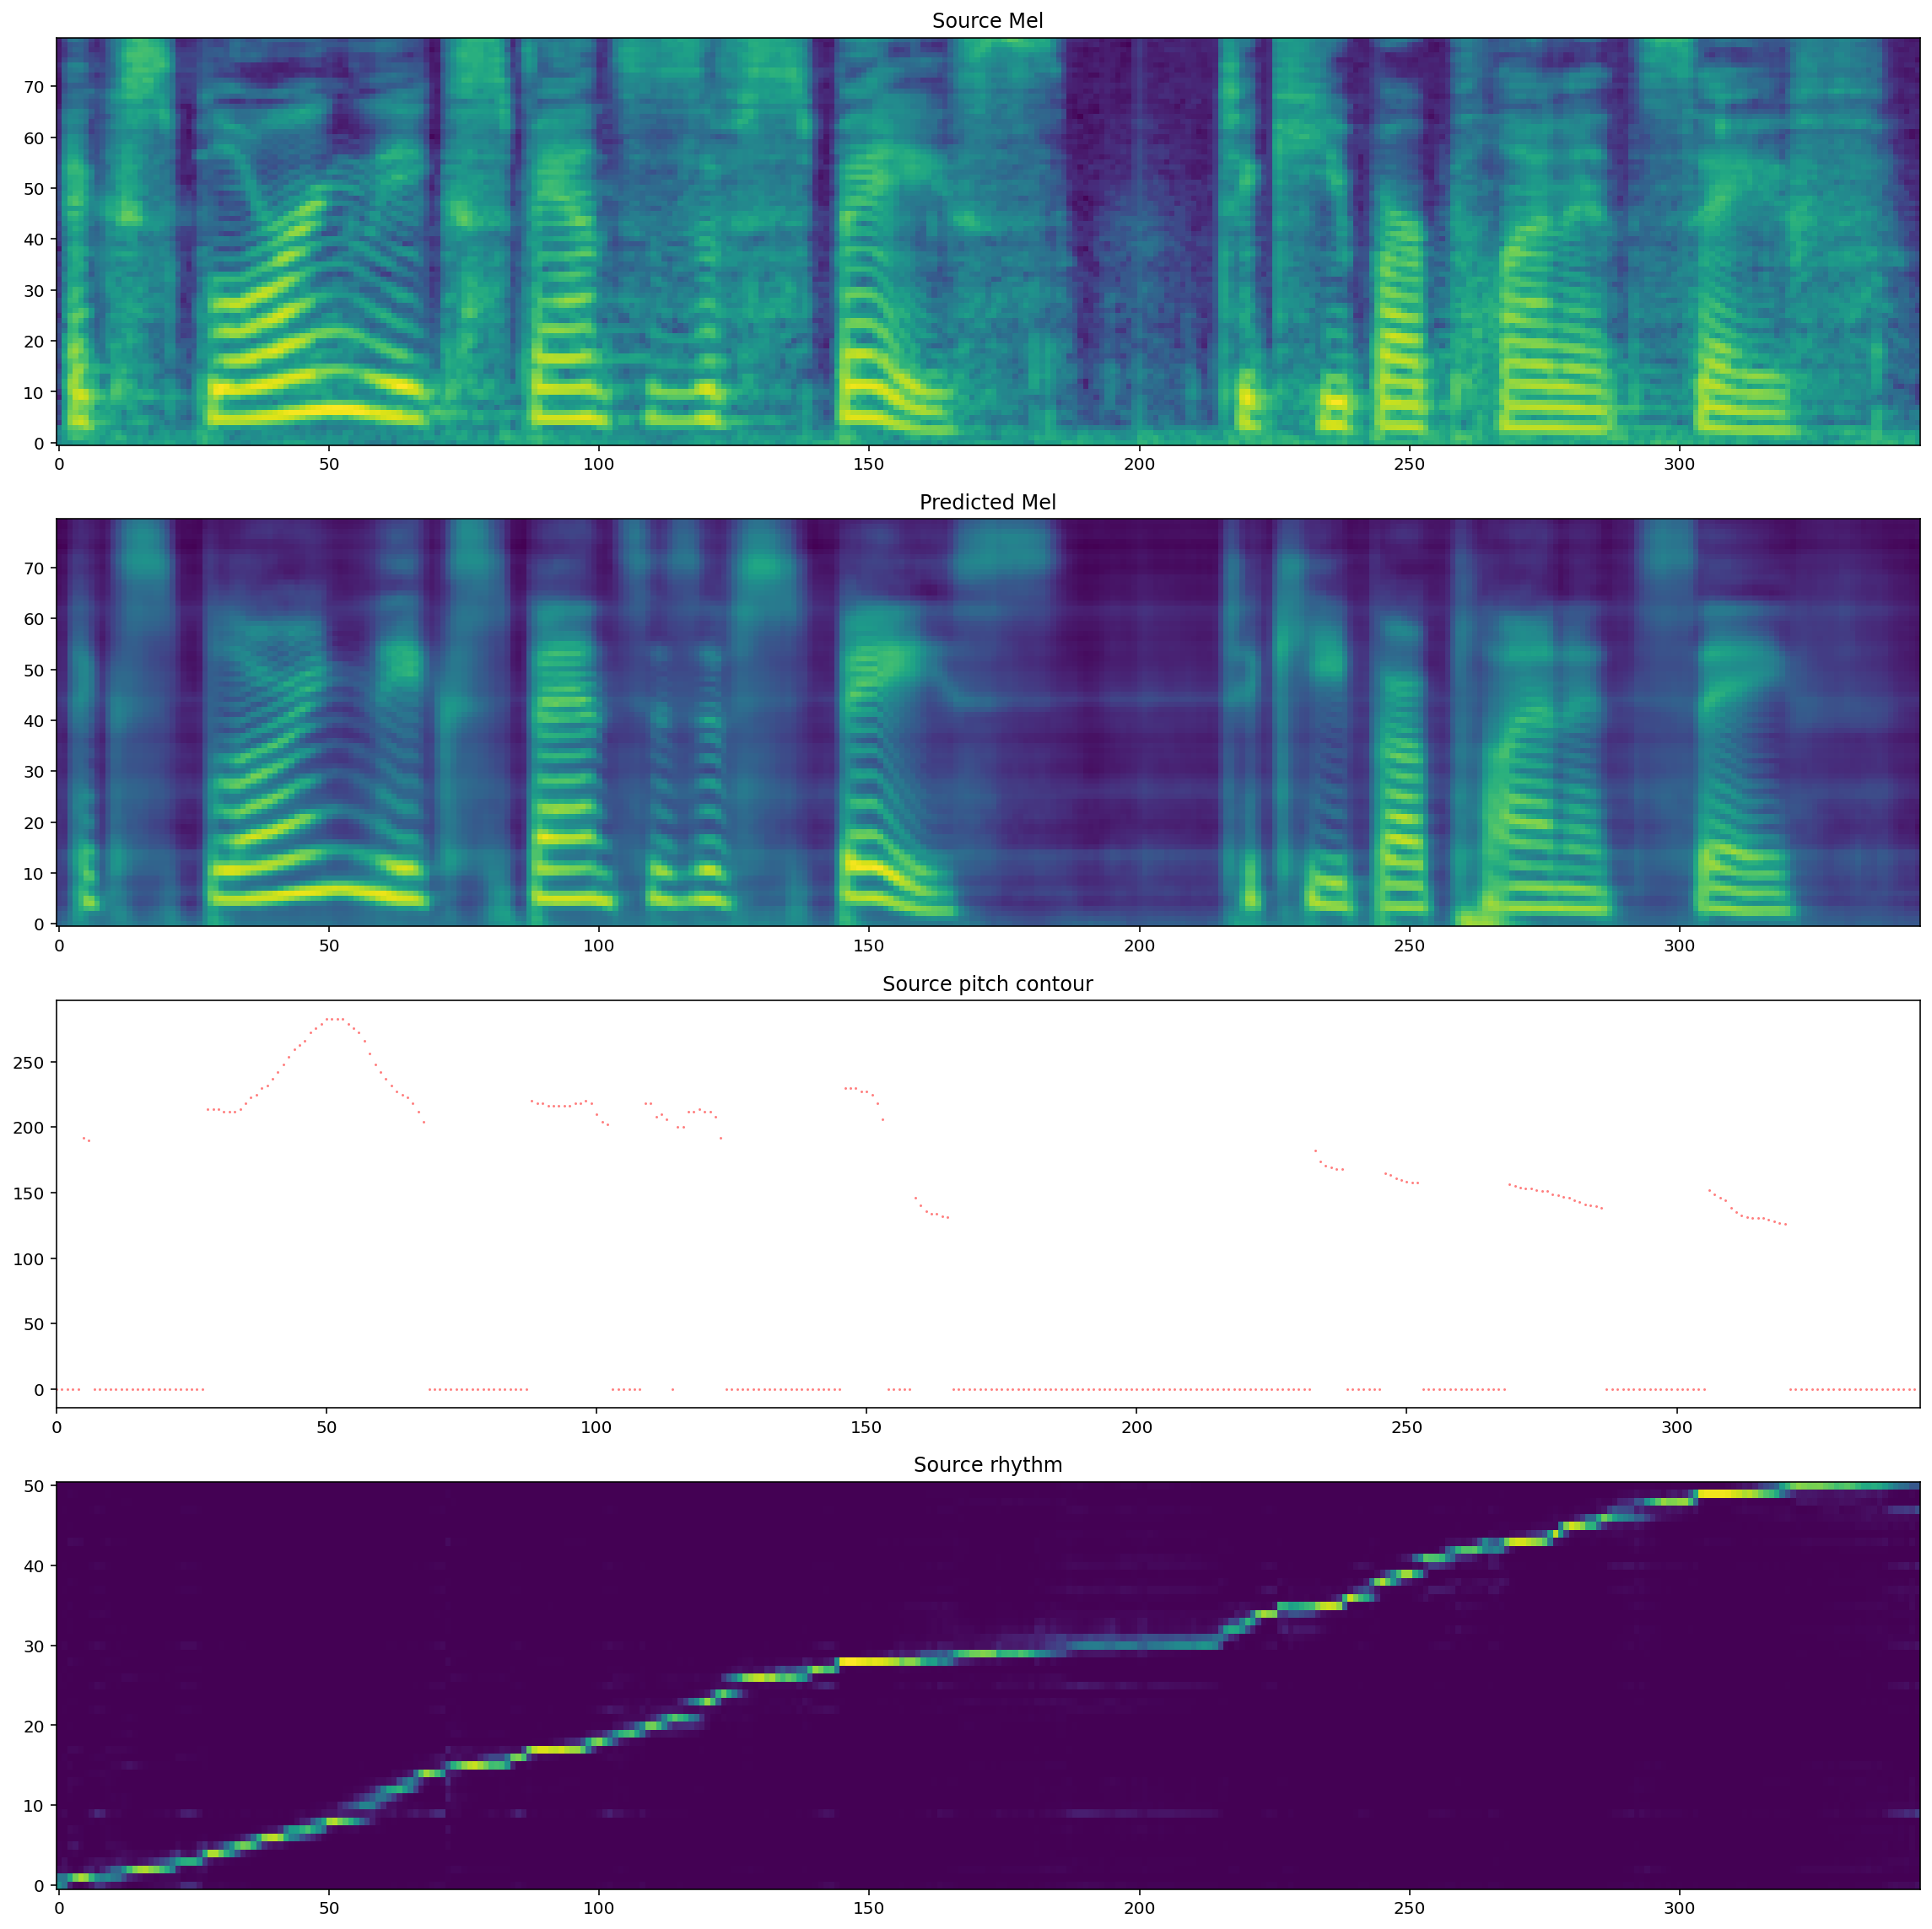

In [ ]:
speaker_id = next(male_speakers)
speaker_id = torch.LongTensor([speaker_id]).cuda()

with torch.no_grad():
    mel_outputs, mel_outputs_postnet, gate_outputs, _ = tacotron.inference_noattention(
        (text_encoded, mel, speaker_id, pitch_contour, rhythm))

plot_mel_f0_alignment(x[2].data.cpu().numpy()[0],
                      mel_outputs_postnet.data.cpu().numpy()[0],
                      pitch_contour.data.cpu().numpy()[0, 0],
                      rhythm.data.cpu().numpy()[:, 0].T)

synthesis voice voice with sigma = 0.8 (default)

In [ ]:
with torch.no_grad():
    audio = denoiser(waveglow.infer(mel_outputs_postnet, sigma=0.8), 0.01)[:, 0]
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

## try other random voice

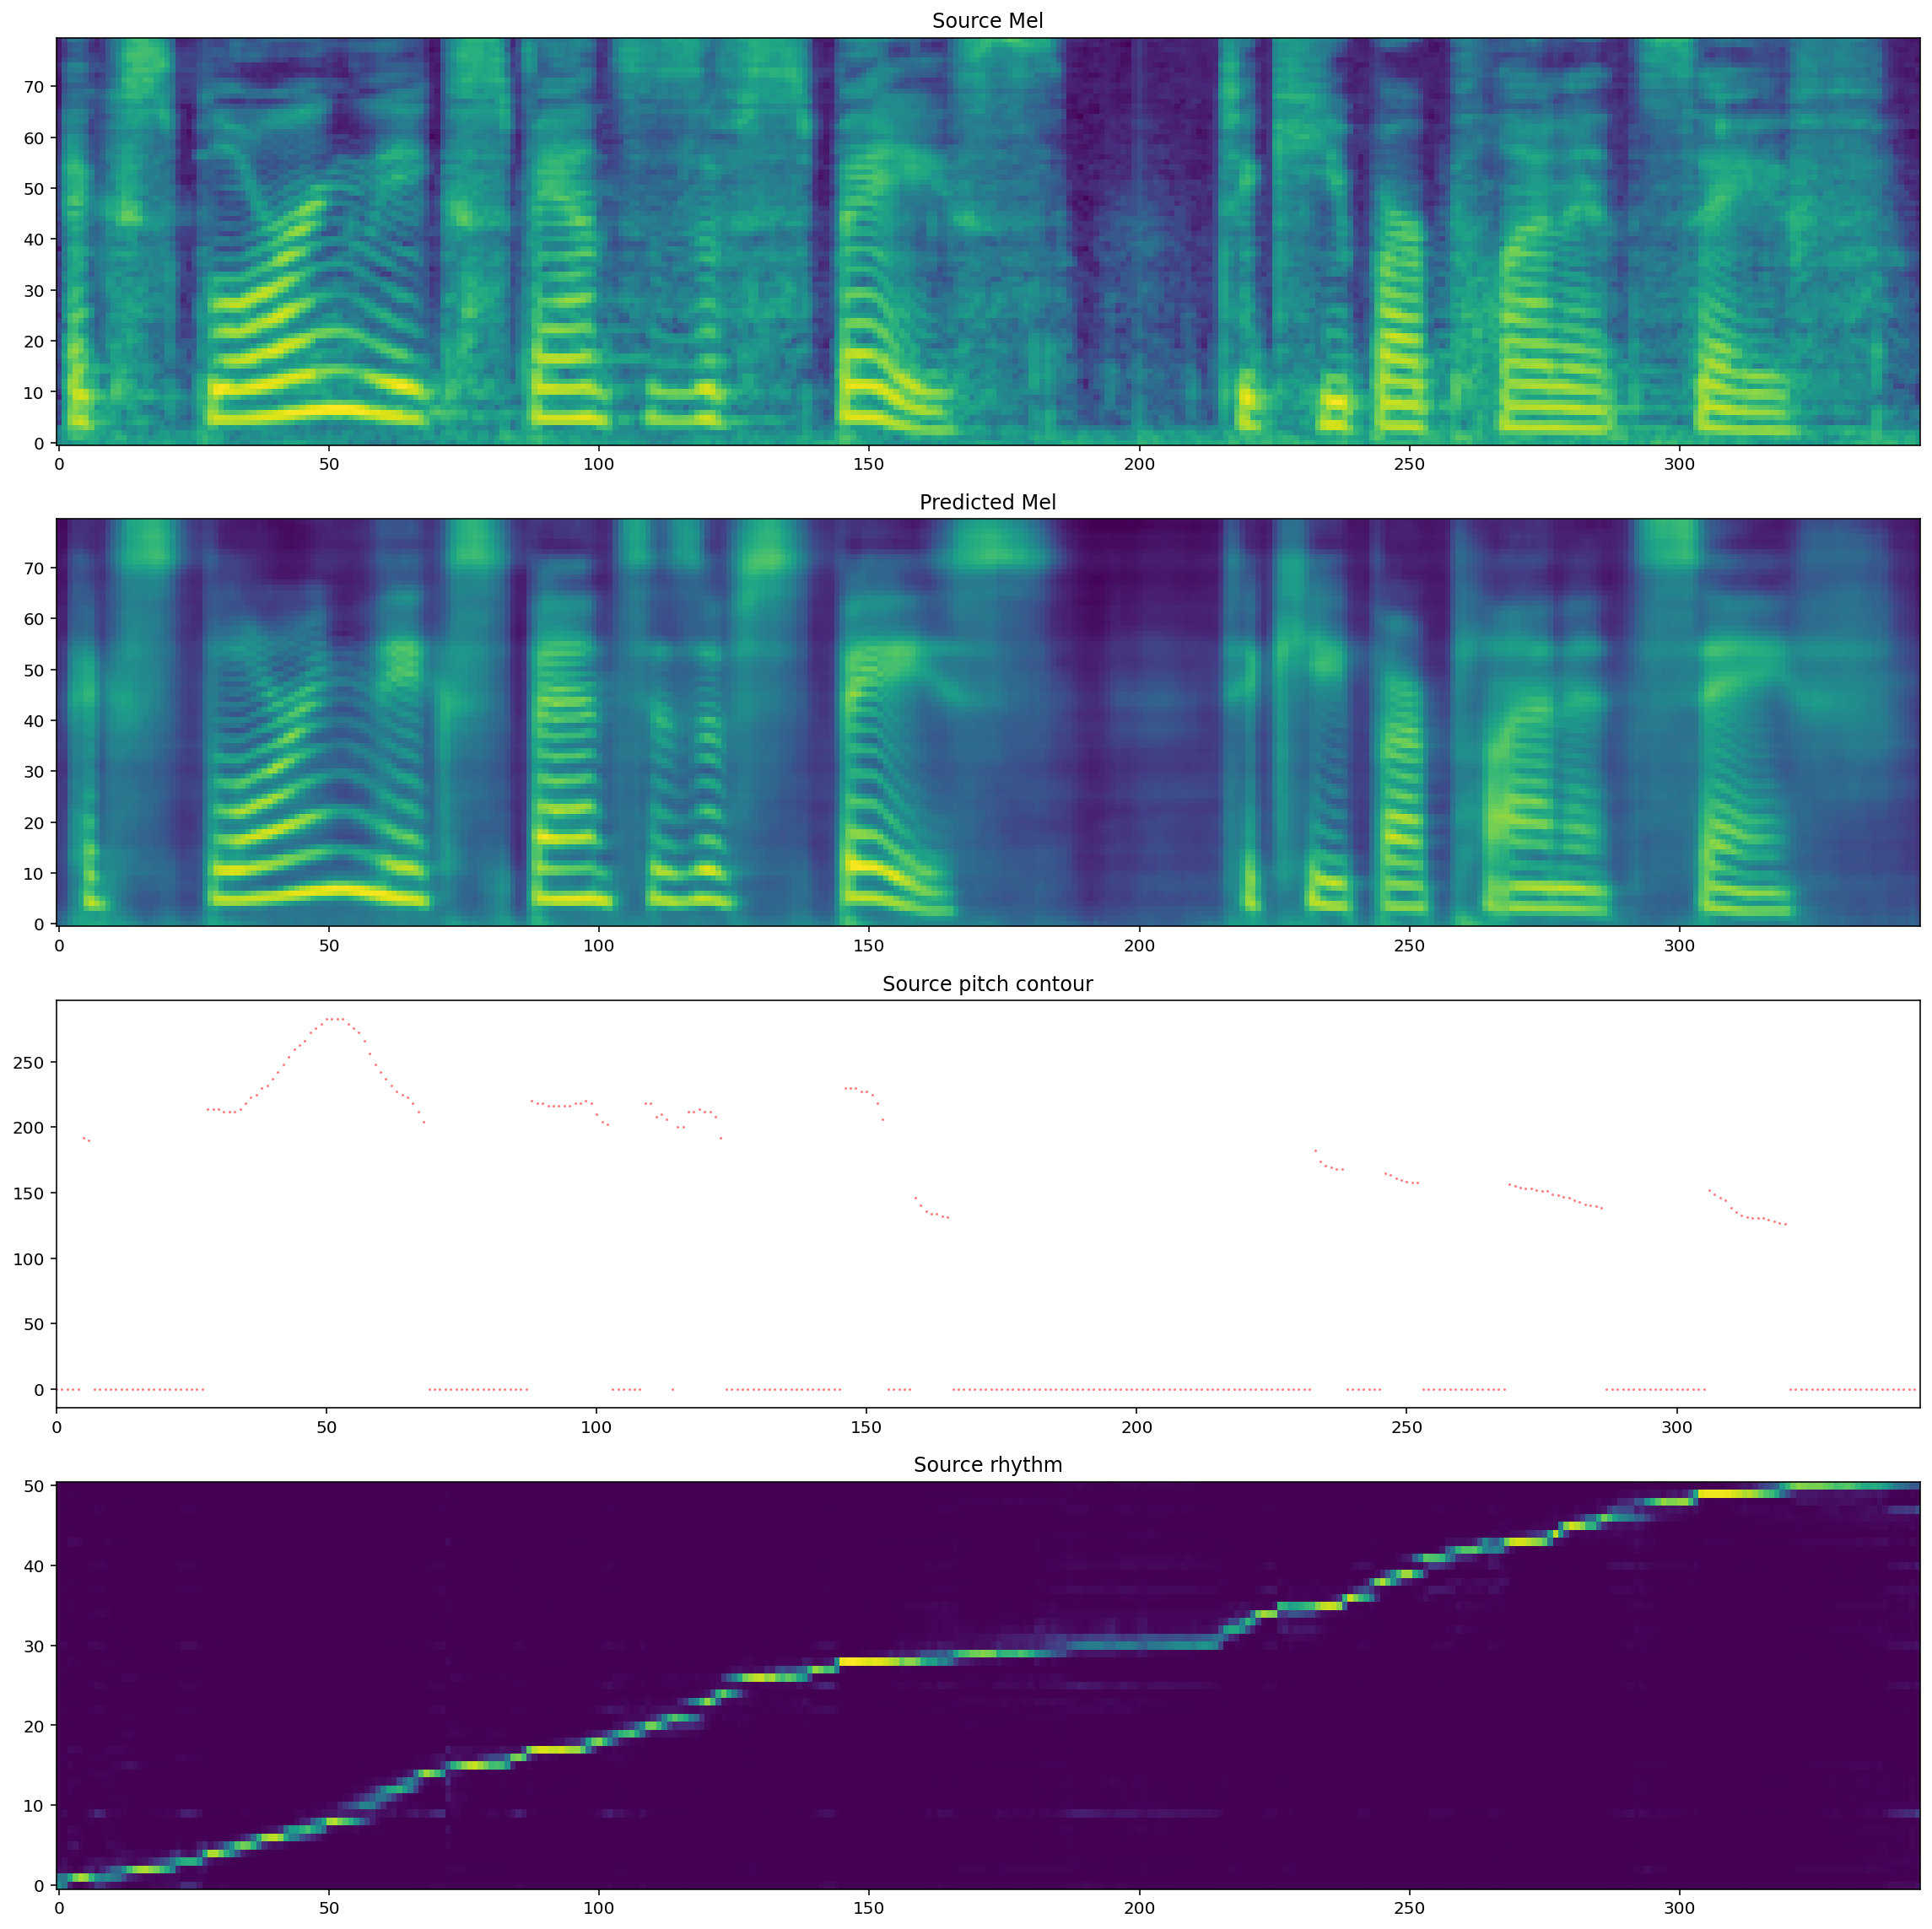

In [ ]:
speaker_id = next(female_speakers) if np.random.randint(2) else next(male_speakers)
speaker_id = torch.LongTensor([speaker_id]).cuda()

with torch.no_grad():
    mel_outputs, mel_outputs_postnet, gate_outputs, _ = tacotron.inference_noattention(
        (text_encoded, mel, speaker_id, pitch_contour, rhythm))

plot_mel_f0_alignment(x[2].data.cpu().numpy()[0],
                      mel_outputs_postnet.data.cpu().numpy()[0],
                      pitch_contour.data.cpu().numpy()[0, 0],
                      rhythm.data.cpu().numpy()[:, 0].T)

synthesis voice voice with sigma =0.9

In [ ]:
with torch.no_grad():
    audio = denoiser(waveglow.infer(mel_outputs_postnet, sigma=0.9), 0.01)[:, 0]
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

## Singing Voice from Music Score


In [ ]:
data = get_data_from_musicxml('/content/mellotron/data/haendel_hallelujah.musicxml', 132, convert_stress=True)
panning = {'Soprano': [-60, -30], 'Alto': [-40, -10], 'Tenor': [30, 60], 'Bass': [10, 40]}

In [ ]:
n_speakers_per_part = 4
frequency_scaling = 0.4
n_seconds = 90
audio_stereo = np.zeros((hparams.sampling_rate*n_seconds, 2), dtype=np.float32)
for i, (part, v) in enumerate(data.items()):
    rhythm = data[part]['rhythm'].cuda()
    pitch_contour = data[part]['pitch_contour'].cuda()
    text_encoded = data[part]['text_encoded'].cuda()
    
    for k in range(n_speakers_per_part):
        pan = np.random.randint(panning[part][0], panning[part][1])
        if any(x in part.lower() for x in ('soprano', 'alto', 'female')):
            speaker_id = torch.LongTensor([next(female_speakers)]).cuda()
        else:
            speaker_id = torch.LongTensor([next(male_speakers)]).cuda()
        print("{} MellotronID {} pan {}".format(part, speaker_id.item(), pan))

        with torch.no_grad():
            mel_outputs, mel_outputs_postnet, gate_outputs, alignments_transfer = tacotron.inference_noattention(
                (text_encoded, mel, speaker_id, pitch_contour*frequency_scaling, rhythm))

            audio = denoiser(waveglow.infer(mel_outputs_postnet, sigma=0.8), 0.01)[0, 0]
            audio = audio.cpu().numpy()
            audio = panner(audio, pan)
            audio_stereo[:audio.shape[0]] += audio            
            write("{} {}.wav".format(part, speaker_id.item()), hparams.sampling_rate, audio)

In [ ]:
audio_stereo = audio_stereo / np.max(np.abs(audio_stereo))
write("audio_stereo.wav", hparams.sampling_rate, audio_stereo)
ipd.Audio([audio_stereo[:,0], audio_stereo[:,1]], rate=hparams.sampling_rate)

## end of notebook